# Some utilities to check my dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import math
import datetime
import sqlalchemy

In [2]:
with open("../localconfig.json", "r") as f:
	config = json.load(f)

# Load entire dataset.

In [3]:
connectionstr = f"mysql+pymysql://{config['solardb_user']}:{config['solardb_pass']}@{config['solardb_host']}/{config['solardb_name']}?charset=utf8mb4"
engine = sqlalchemy.create_engine(connectionstr)
engine.connect()

#solardf = pd.read_sql_table('production', engine)
sql =  '''
SELECT production_key, datetime, consumption, production FROM production 
	ORDER by datetime asc
'''
solardf = pd.read_sql(sql, engine)

In [4]:
solardf

,production_key,datetime,consumption,production
0,285,2022-06-07 09:34:00.150,529.433,3600.19
1,286,2022-06-07 09:34:10.330,530.003,3606.24
2,287,2022-06-07 09:34:20.380,532.417,3605.58
3,288,2022-06-07 09:34:30.510,418.868,3604.08
4,289,2022-06-07 09:34:40.550,421.551,3608.15
...,...,...,...,...
66708,66709,2022-07-01 14:29:51.960,448.377,6859.33
66709,66710,2022-07-01 14:30:02.000,450.243,6863.06
66710,66711,2022-07-01 14:30:12.040,442.056,6864.81
66711,66712,2022-07-01 14:30:22.190,438.241,6861.46


# some basic data checks.

In [5]:
solardf['consumption'].describe()

count    66713.000000
mean       727.771602
std        727.812977
min        164.181000
25%        328.737000
50%        448.010000
75%        884.351000
max      10309.400000
Name: consumption, dtype: float64

In [6]:
solardf['production'].describe()

count    66713.000000
mean      1834.498562
std       2372.550273
min          0.000000
25%          0.000000
50%        387.162000
75%       3368.110000
max       7114.190000
Name: production, dtype: float64

In [7]:
cons = (solardf['consumption'].min(), solardf['consumption'].max())
prod = (solardf['production'].min(), solardf['production'].max())
print (f"consumption min {cons[0]} max {cons[1]}")
print (f"production min {prod[0]} max {prod[1]}")

consumption min 164.181 max 10309.4
production min 0.0 max 7114.19


In [8]:
dt = (solardf[solardf['production'] == prod[1]])['datetime'].values[0]
dt
#dt = (solardf[solardf['production'] == prod[1]]).values[1,0]
#print (dt.strftime('%Y-%m-%d %H:%M:%S'))

numpy.datetime64('2022-06-27T14:29:21.360000000')

# Plots which let us visualize the distribution.

<AxesSubplot:>

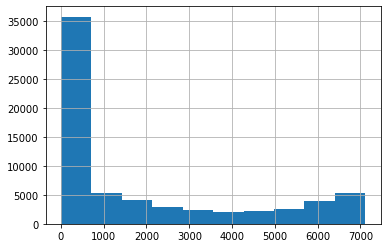

In [9]:
solardf['production'].hist()

<AxesSubplot:>

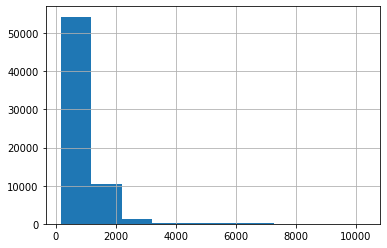

In [10]:
solardf['consumption'].hist()

# Check for gaps in the data series.

Since I log every 10 seconds, look for gaps greater than 60 seconds

In [11]:
# Calculate time interval from previous row.  
#data_intervals = solardf['datetime'].subtract(solardf['datetime'].shift(1)).dropna()
data_intervals = solardf['datetime'].diff().dropna()

# Add two columns:  interval as timedelta and as seconds
solardf['interval'] = data_intervals
solardf['intervalsec'] = data_intervals.apply(lambda x: x.seconds)

In [12]:
longdelayds = solardf[solardf['intervalsec'] > 120]


In [13]:
longdelayds.to_csv(f"local_{config['solardb_name']}_{config['solardb_table']}_longdelay.csv")

720


<AxesSubplot:>

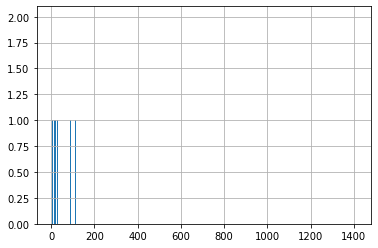

In [14]:
delaymins = longdelayds['intervalsec']/60
bins = math.ceil(delaymins.max()/60) * 30
print (bins)
(longdelayds['intervalsec']/60).hist(bins=bins)

In [15]:
longdelayds

,production_key,datetime,consumption,production,interval,intervalsec
6,291,2022-06-07 09:54:01.790,318.136,4080.560,0 days 00:19:10.910000,1150.0
8,1,2022-06-07 13:40:47.510,376.620,295.283,0 days 03:46:35.640000,13595.0
207,200,2022-06-07 14:47:29.980,1184.660,1314.790,0 days 00:30:37.390000,1837.0
213,206,2022-06-07 16:19:20.980,552.698,3265.140,0 days 01:30:50.710000,5450.0
292,293,2022-06-18 09:39:27.590,1663.020,2052.480,10 days 17:06:53,61613.0
295,296,2022-06-19 09:10:24.940,1719.180,1061.750,0 days 23:30:36.870000,84636.0
373,374,2022-06-19 09:28:01.940,1557.530,1306.830,0 days 00:03:23.950000,203.0
454,455,2022-06-19 10:00:50.250,336.426,1263.590,0 days 00:17:20.170000,1040.0
457,458,2022-06-19 10:18:21.780,595.167,1890.960,0 days 00:17:10.830000,1030.0
462,463,2022-06-19 10:35:40.600,1513.020,1547.190,0 days 00:16:21.750000,981.0
